# **Description**
In this notebook you will firstly train a CNN on cifar10 dataset. The CNN architecture is provided in ``` resnet.py ```. Then you are going to implement targeted and untargeted FGSM attack and also $l_{∞}$-PGD attack, and evaluate the performance of the trained model on the adversarial data.

# **Setups**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pickle
import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

from resnet import *

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
'''
These are the default values for variables, these should work, but if needed, you are allowed to change these parameters.
'''

batch_size = 256
lr = 1e-3
epochs = 100

# **Data Preparation**
Use cifar10 dataset provided in torchvision and create train and test dataloaders according to the given transformations.

In [98]:
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


# **Building The Model**

In [6]:
########################################
#build your model                      #
########################################
print('==> Building model..')
net = ResNet18()
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

optimizer = optim.Adam(net.parameters(), lr=lr)

==> Building model..


# **Training and Evaluating The Model**

In [7]:
# Training
def train(epoch, net, optimizer, trainloader):
    print('\nEpoch: %d' % epoch)
    net.train()
    criterion = nn.CrossEntropyLoss()

    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/len(trainloader), 100*correct/total


def test(epoch, net, testloader):
    net.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/len(testloader), 100 * correct / total

In [ ]:
######################################################################
#train your model, make sure to save loss and accuracy in all epochs #
######################################################################

train_accuracies, test_accuracies= [], []
train_losses, test_losses = [], []
epochs = 10

for epoch in range(epochs):
    train_loss, train_accuracy = train(epoch, net, optimizer, train_dataloader)
    test_loss, test_accuracy = test(epoch, net, test_dataloader)

    print(f'TRAIN LOSS: {train_loss}, TEST LOSS: {test_loss}, TRAIN ACC: {train_accuracy}%, TEST ACC: {test_accuracy}%')
    print(10 * '-')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


Epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TRAIN LOSS: 1.5054536297613261, TEST LOSS: 1.2434325039386749, TRAIN ACC: 44.614%, TEST ACC: 56.27%
----------

Epoch: 1
TRAIN LOSS: 1.00388181939417, TEST LOSS: 1.2768470346927643, TRAIN ACC: 64.212%, TEST ACC: 58.02%
----------

Epoch: 2
TRAIN LOSS: 0.796981003211469, TEST LOSS: 0.7909970089793206, TRAIN ACC: 71.49%, TEST ACC: 72.59%
----------

Epoch: 3
TRAIN LOSS: 0.6639066808381859, TEST LOSS: 0.7820628911256791, TRAIN ACC: 76.648%, TEST ACC: 74.34%
----------

Epoch: 4
TRAIN LOSS: 0.5707147224825255, TEST LOSS: 0.6269344910979271, TRAIN ACC: 80.04%, TEST ACC: 78.5%
----------

Epoch: 5
TRAIN LOSS: 0.5039675833315266, TEST LOSS: 0.6400034420192242, TRAIN ACC: 82.432%, TEST ACC: 79.13%
----------

Epoch: 6
TRAIN LOSS: 0.4470333715482634, TEST LOSS: 0.6361525699496269, TRAIN ACC: 84.492%, TEST ACC: 79.73%
----------

Epoch: 7
TRAIN LOSS: 0.40740131845279615, TEST LOSS: 0.44121360033750534, TRAIN ACC: 85.834%, TEST ACC: 84.55%
----------

Epoch: 8
TRAIN LOSS: 0.3743559702166489, TEST

In [ ]:
########################################
#save your model and history           #
########################################
torch.save(net.state_dict(), './drive/MyDrive/resnet18.pt')
with open('./drive/MyDrive/history.pkl', 'wb') as f:
    pickle.dump((train_accuracies, test_accuracies, train_losses, test_losses), f)


## **Train and Test Loss and Accuracy Plots**

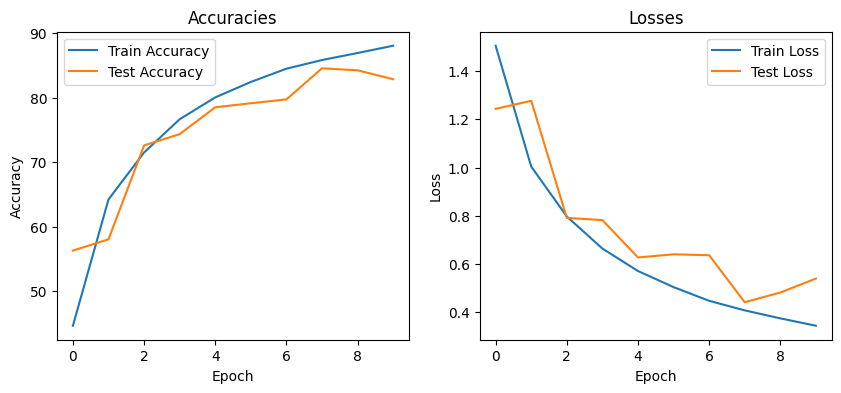

In [ ]:
#############################################################
#plot train and test loss and accuracy dusring the training #
#############################################################

import matplotlib.pyplot as plt

def plot_accuracies_and_losses(train_accuracies, test_accuracies, train_losses, test_losses):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(train_accuracies, label='Train Accuracy')
    ax1.plot(test_accuracies, label='Test Accuracy')
    ax1.set_title('Accuracies')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(train_losses, label='Train Loss')
    ax2.plot(test_losses, label='Test Loss')
    ax2.set_title('Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()


plot_accuracies_and_losses(train_accuracies, test_accuracies, train_losses, test_losses)

# **FGSM Attack**

In this section you must implement targeted and untargeted FGSM attack and evalute the trained model performance on the adversarial data.

## **Untargeted FGSM Attack**

In [99]:
########################################
#define untargeted FGSM attack         #
########################################


def FGSM(model, x, y, epsilon):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: clipping threshold for FGSM

  outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """
  delta = None
  model.eval()
  x = torch.tensor(x, requires_grad=True).to(device)
  loss = F.cross_entropy(model(x), y)
  model.zero_grad()
  loss.backward()
  delta = epsilon * x.grad.detach().sign()
  return x+delta, delta, model(x+delta)

###**Evaluation**


 For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [ ]:
######################
# Your code goes here

epsilons = [1/255, 4/255, 8/255]
loss_fn = nn.CrossEntropyLoss()
net.eval()

for epsilon in epsilons:
    test_loss = 0
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        x_adversarial, delta, out_adversarial = FGSM(net, images, labels, epsilon)
        loss = loss_fn(out_adversarial, labels)
        test_loss += loss.item()
        predictions = torch.argmax(out_adversarial, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    print(f'EPSILON: {epsilon}, TEST LOSS: {test_loss / len(test_dataloader)}, TEST ACC: {round(100 * correct / total, 2)}')

<ipython-input-9-070eb95800b9>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True).to(device)


EPSILON: 0.00392156862745098, TEST LOSS: 0.8035684242844582, TEST ACC: 75.1
EPSILON: 0.01568627450980392, TEST LOSS: 1.9794514805078507, TEST ACC: 51.11
EPSILON: 0.03137254901960784, TEST LOSS: 3.8267365872859953, TEST ACC: 28.51


### **FGSM by gradually increasing $ϵ$**

FGSM attack may not work for small $\epsilon$, on the other hand we want to alter image as insignificant as possible, so here is what we do, we start from $\epsilon = \frac{1}{255}$ and if the attack was unsuccessful, we increase $\epsilon$ by $\frac{1}{255}$. The procedure goes on until the predicted label is different from the ground truth.

In [11]:
#######################################################
#increase epsilon gradually till the label is changed. The function can be implemented recursively.#
#######################################################

def generate_adversarial_FGSM (model, x, label, initial_epsilon=1/255):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: intial clipping threshold for FGSM

  outputs:
    epsilon: the epsilon that flips the label.
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """

  delta = None
  model.eval()
  x = torch.tensor(x, requires_grad=True).to(device)
  loss = F.cross_entropy(model(x), label)
  model.zero_grad()
  loss.backward()
  delta = initial_epsilon * x.grad.detach().sign()

  x_adversarial = x + delta

  out_adversarial = model(x_adversarial)
  predictions = torch.argmax(out_adversarial, 1)

  correct = (predictions == label).sum()
  total = label.size(0)

  if total == correct:
      initial_epsilon, delta, out_adversarial, x_adversarial = generate_adversarial_FGSM(model, x, label, initial_epsilon + 1/255)

  return initial_epsilon, delta, out_adversarial, x_adversarial

### **Visualization**
Pick 10 samples from cifar10 test set, each from one class, make sure the selected samples are classified correctly. Plot these samples. Take note that the selected data must not be transformed by train or test transformations while visualisation.

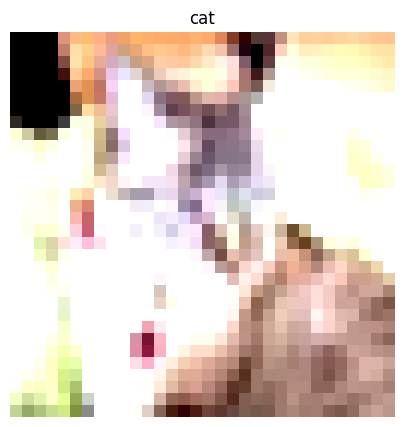

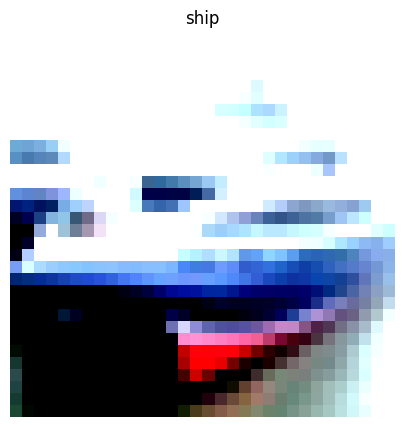

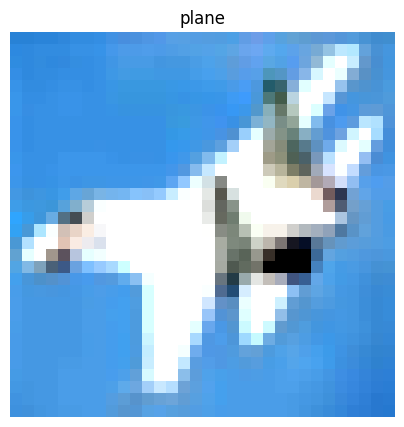

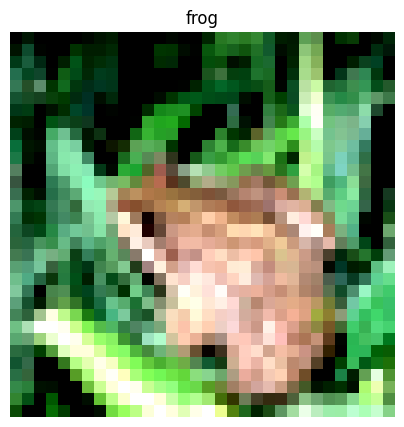

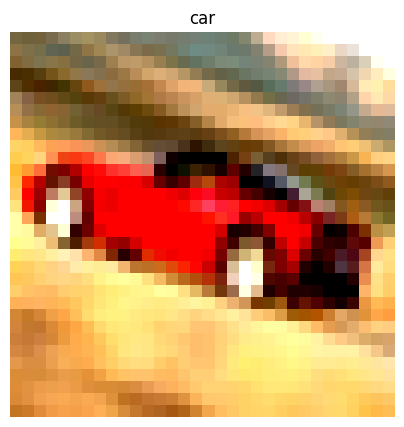

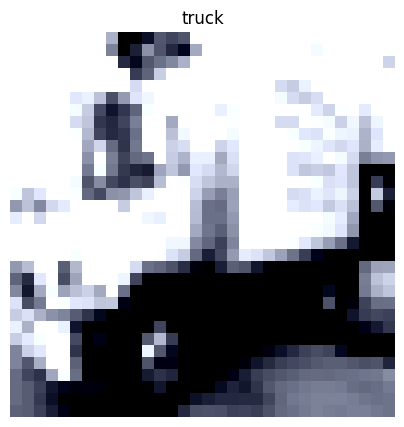

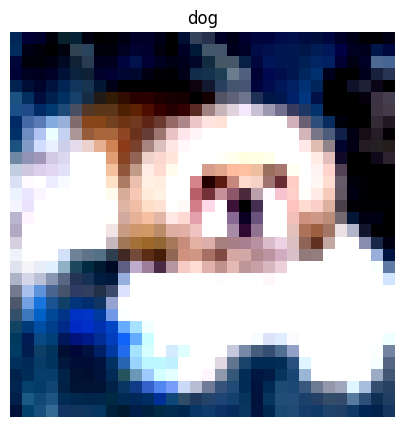

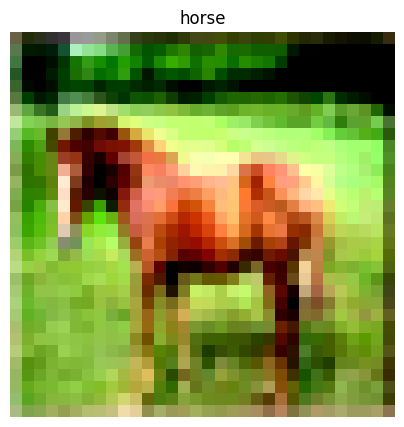

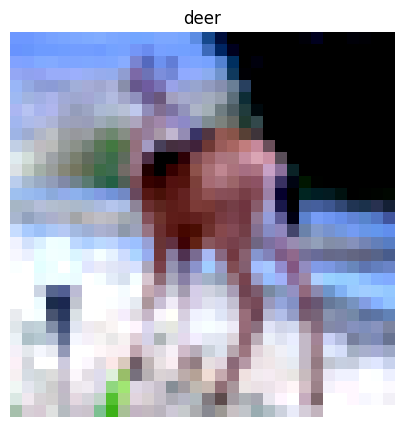

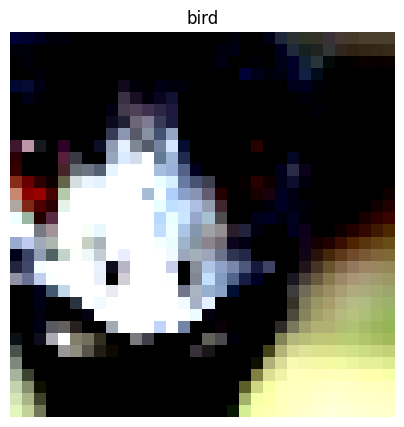

In [100]:
#############################################################################################
#visualize one test sample from each class and make sure that they are correctly labeled.   #
#save index of these samples, since they are needed in the following sections.              #
#############################################################################################
def imshow(img, title=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(5, 5))  # Set the figure size
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


net.eval()
class_indices = {}
for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

samples = []
for label, indices in class_indices.items():
    for i in indices:
        # Check if the sample is classified correctly
        image, target = test_dataset[i]
        if torch.argmax(net(image.to(device).unsqueeze(0))) == target:
            samples.append([image, target, i])
            break
    if len(samples) == 10:
        break


for image, label, index in samples:
    imshow(image, classes[label])

Now, apply untargetted FGSM attack ``` generate_adversarial_FGSM ``` on the selected samples. Visualize the original image, the perturbed image, and the perturbation. since the perturbation is imperceptible, magnify it by the value of $\frac{1}{\epsilon}$ before visualization.

<ipython-input-11-469c9d61ef88>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True).to(device)


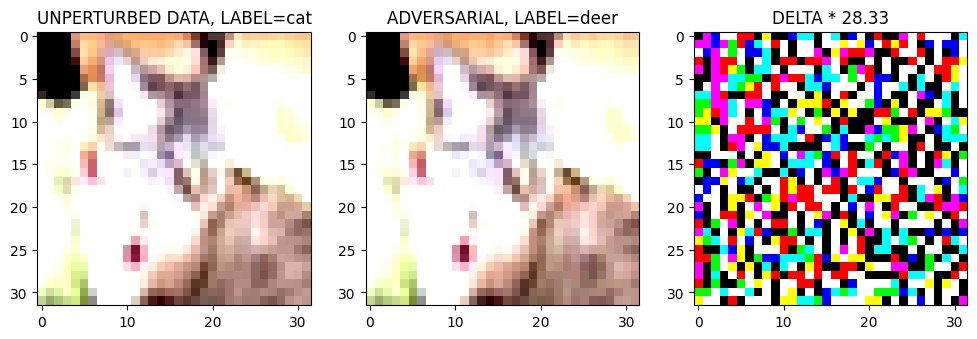

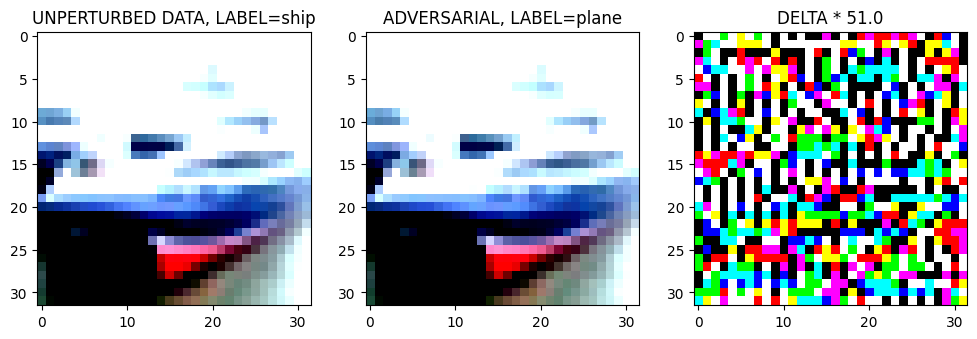

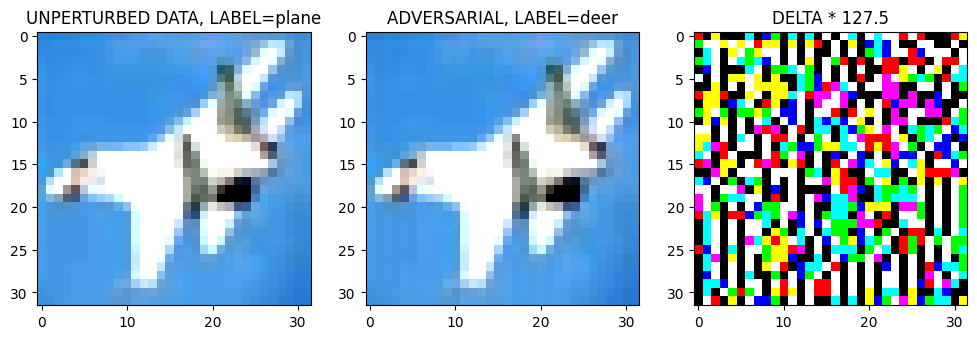

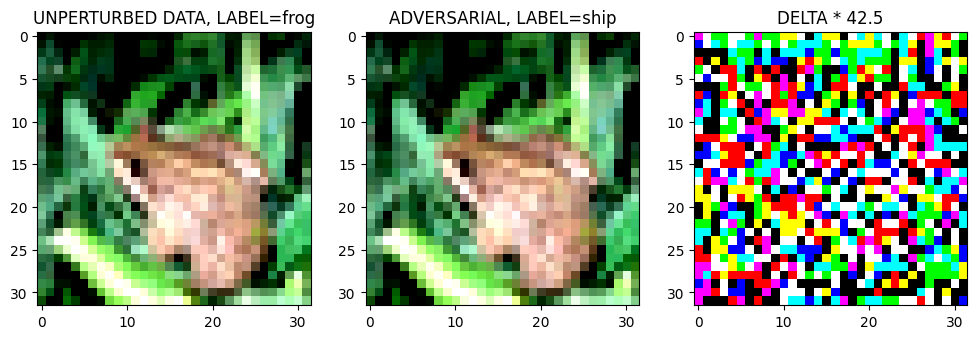

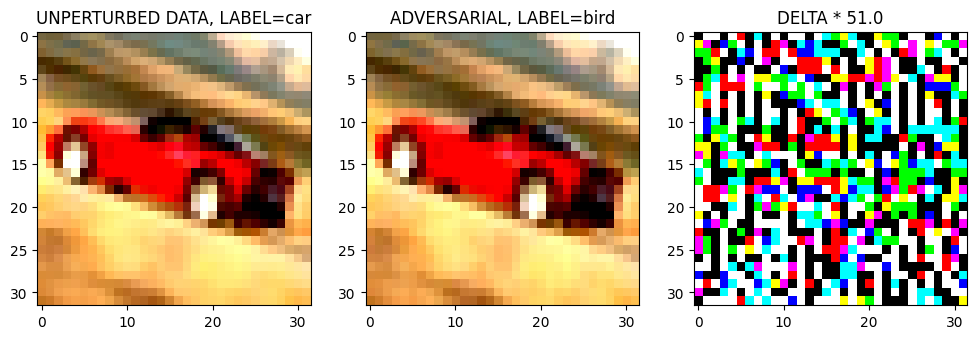

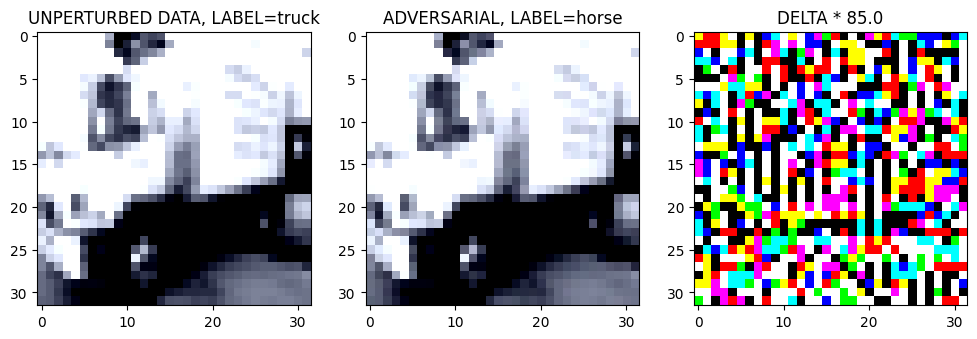

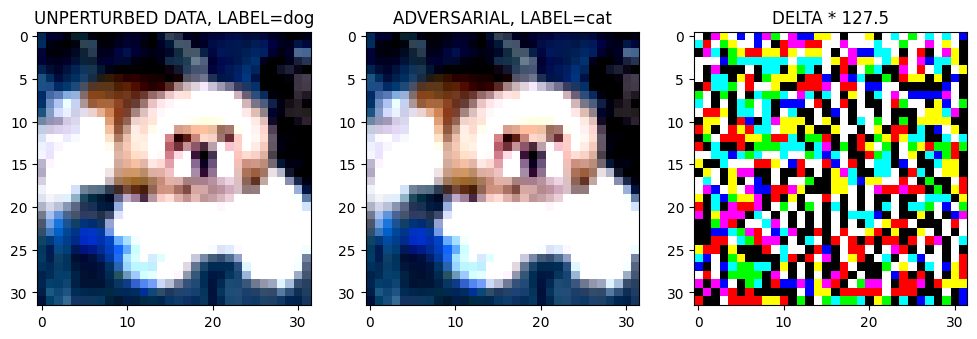

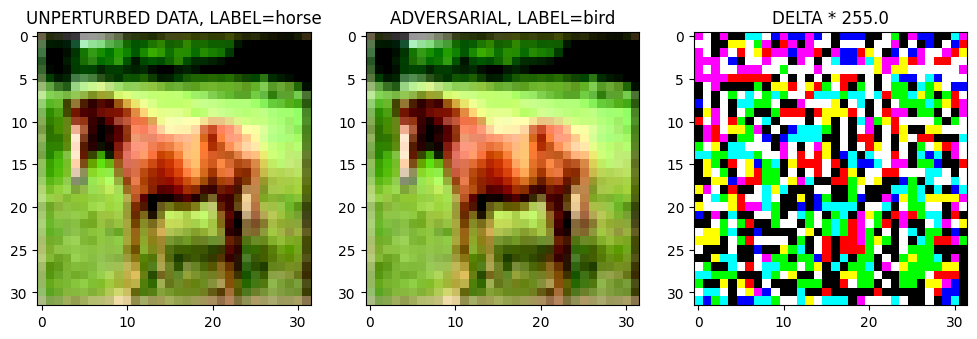

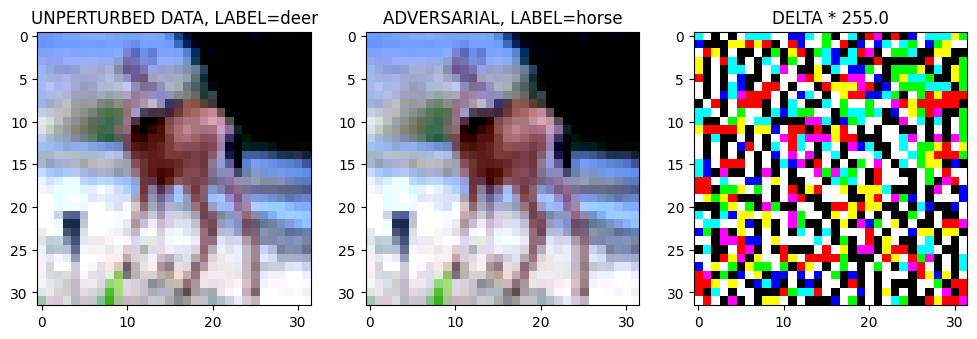

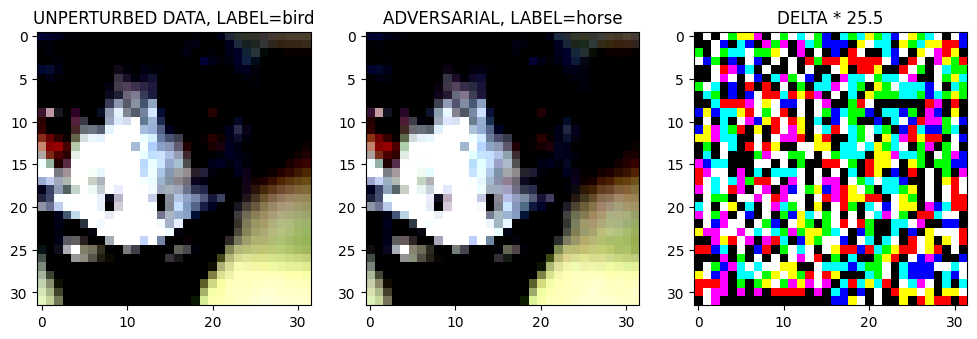

In [101]:
######################################################################################################
#visualize the selected samples, their corresponding perturbed image, and the magnified perturbation #
#also print the ground truth and the predicted label for each sample                                 #
######################################################################################################

def denormalize(tensor):
    return tensor / 2 + 0.5

def to_cpu(tensor):
    return tensor.detach().cpu()


for image, label, index in samples:
    image = image.to(device)
    label = torch.tensor(label).unsqueeze(0).to(device)
    initial_epsilon, delta, out_adversarial, x_adversarial =  generate_adversarial_FGSM (net, image.unsqueeze(0), label, initial_epsilon=1/255)
    adversarial_label = torch.argmax(out_adversarial)

    image, label, delta, adversarial_label, x_adversarial = to_cpu(image), to_cpu(label).squeeze(), to_cpu(delta).squeeze(), to_cpu(adversarial_label).squeeze(), to_cpu(x_adversarial).squeeze()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))


    image = denormalize(image)
    npimg = image.numpy()
    axs[0].imshow(np.transpose(npimg, (1, 2, 0)))
    axs[0].set_title(f'UNPERTURBED DATA, LABEL={classes[label]}')

    adversarial_image =  denormalize(x_adversarial)
    npadvimg = adversarial_image.numpy()
    axs[1].imshow(np.transpose(npadvimg, (1, 2, 0)))
    axs[1].set_title(f'ADVERSARIAL, LABEL={classes[adversarial_label]}')

    added_noise = 1 / initial_epsilon * delta
    added_noise = denormalize(added_noise)
    np_added_noise = added_noise.numpy()
    axs[2].imshow(np.transpose(np_added_noise, (1, 2, 0)))
    axs[2].set_title(f'DELTA * {round(1 / initial_epsilon, 2)}')
    plt.show()

## **Targeted FGSM Attack**
implement targeted FGSM attack.

In [16]:
########################################
#define tergeted FGSM attack           #
########################################

def FGSM_targeted (model, x, y, y_targ, epsilon):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    y_targ = target label
    epsilon: clipping threshold for FGSM

  outputs:
    x': the perturbed image
    delta: the added perturbation
  """

  delta = None
  model.eval()

  x = torch.tensor(x, requires_grad=True).to(device)
  loss = F.cross_entropy(model(x), y_targ)
  model.zero_grad()
  loss.backward()
  delta = epsilon * x.grad.detach().sign()
  return x-delta, delta

### **Evaluation**
for each sample, select the most probable lable as the target label (if the most probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [92]:
def get_target_label_most(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).float()
    second_most_probable = torch.argsort(outputs, dim=1)[:, -2]
    target = correct * second_most_probable + (1 - correct) * predicted
    return target.long()


epsilons = [1/255, 4/255, 8/255]
loss_fn = nn.CrossEntropyLoss()
net.eval()


fgsm_targeted_test_losses = []
fgsm_targeted_test_accuracy = []

for epsilon in epsilons:
    test_loss = 0
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        probabilities = net(images)
        targets = get_target_label_most(probabilities, labels)
        x_adversarial, delta = FGSM_targeted(net, images, labels, targets, epsilon)
        out_adversarial = net(x_adversarial)

        loss = loss_fn(out_adversarial, targets)
        test_loss += loss.item()
        predictions = torch.argmax(out_adversarial, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    fgsm_targeted_test_losses.append(test_loss / len(test_dataloader))
    fgsm_targeted_test_accuracy.append(100 * correct / total)

    print(f'EPSILON: {epsilon}, TEST LOSS: {test_loss / len(test_dataloader)}, TEST ACC: {round(100 * correct / total, 2)}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-bf5eff28c387>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True).to(device)


EPSILON: 0.00392156862745098, TEST LOSS: 4.149052673578263, TEST ACC: 75.06
EPSILON: 0.01568627450980392, TEST LOSS: 2.3437400996685027, TEST ACC: 50.56
EPSILON: 0.03137254901960784, TEST LOSS: 1.2129275500774384, TEST ACC: 27.98


for each sample, select the least probable lable as the target label (if the least probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [94]:
######################
# Your code goes here
######################
# Your code goes here

def get_target_label_least(outputs, labels):
    _, predicted = torch.min(outputs, 1)
    correct = (predicted == labels).float()
    second_least_probable = torch.argsort(-1 * outputs, dim=1)[:, -2]
    target = correct * second_least_probable + (1 - correct) * predicted
    return target.long()


epsilons = [1/255, 4/255, 8/255]
loss_fn = nn.CrossEntropyLoss()
net.eval()


fgsm_targeted_test_losses_least = []
fgsm_targeted_test_accuracy_least = []

for epsilon in epsilons:
    test_loss = 0
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        probabilities = net(images)
        targets = get_target_label_least(probabilities, labels)
        x_adversarial, delta = FGSM_targeted(net, images, labels, targets, epsilon)
        out_adversarial = net(x_adversarial)

        loss = loss_fn(out_adversarial, targets)
        test_loss += loss.item()
        predictions = torch.argmax(out_adversarial, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    fgsm_targeted_test_losses_least.append(test_loss / len(test_dataloader))
    fgsm_targeted_test_accuracy_least.append(100 * correct / total)
    print(f'EPSILON: {epsilon}, TEST LOSS: {test_loss / len(test_dataloader)}, TEST ACC: {round(100 * correct / total, 2)}')

<ipython-input-16-bf5eff28c387>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True).to(device)


EPSILON: 0.00392156862745098, TEST LOSS: 14.847595167160033, TEST ACC: 82.26
EPSILON: 0.01568627450980392, TEST LOSS: 12.047733521461486, TEST ACC: 71.51
EPSILON: 0.03137254901960784, TEST LOSS: 9.572825932502747, TEST ACC: 50.48


plot accuracy of model with respect to $\epsilon$ both for least probable and most probable target labels (both in a single plot).

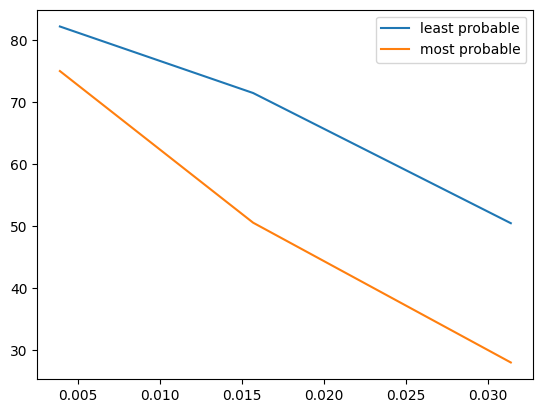

In [27]:
######################
# Your code goes here
fig, ax = plt.subplots()

plt.plot(epsilons, fgsm_targeted_test_accuracy_least)
plt.plot(epsilons, fgsm_targeted_test_accuracy)

ax.legend(['least probable', 'most probable'])
plt.show()

# **PGD Attack**

Implement PGD attack in the following cell. There is no need to change the default $\epsilon$ and $\alpha$.

In [86]:
def PGD(model, x, y, iterations, epsilon=8/255, alpha=3/255):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    iterations: number of iterations for PGD attack
    epsilon: clipping threshold for PGD
    alpha: step size for PGD attack

  outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """
  init_x = x.clone().detach()
  x = torch.tensor(x, requires_grad=True).to(device)
  for i in range(iterations):
      x.requires_grad = True
      predictions = model(x)
      loss = F.cross_entropy(predictions, y)
      model.zero_grad()
      loss.backward()
      delta = alpha * x.grad.detach().sign()
      x = x.detach() + delta.detach()
      x = torch.min(torch.max(x, init_x - epsilon), init_x + epsilon)
      x = torch.clamp(x, 0, 1)
  return x

## **Evaluation**
for iterations $\in \{3, 7, 12\}$, evaluate performance of the model on adversarial test data.

In [97]:
######################
# Your code goes here
# Define the number of iterations to use for PGD attack

iterations_list = [3, 7, 12]
net.eval()
for iterations in iterations_list:
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        x_adversarial = PGD(net, images, labels, iterations=iterations)
        y_adversarial = net(x_adversarial)
        predictions = torch.argmax(y_adversarial, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
    print(f'ITERATIONS: {iterations}, TEST ACC: {round(100 * correct / total, 2)}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-86-981a188c86ab>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True).to(device)


ITERATIONS: 3, TEST ACC: 22.85
ITERATIONS: 7, TEST ACC: 15.69
ITERATIONS: 12, TEST ACC: 15.18


# **Questions**

1. What was the effect of $\epsilon$ in targeted and untargeted FGSM attack according to your observations?

as we can see in the results, the more the epsilon, the more perturbed the adversarial image and the less accurate the model performs because the images become very noisy and is hard for the model to predict the correct class.

2. Compare performance of the model on the least probable and most probable targetted FGSM attacks, justify your observation.

model is more sensitive to perturbations in the direction of the most probable output than in the direction of the least probable output. This could be because the model has learned to assign a higher confidence score to the most probable output, and is therefore more likely to make mistakes when the input is perturbed in that direction. On the other hand, the model may have learned to assign a lower confidence score to the least probable output, and is therefore more robust to perturbations in that direction.


3. What was the effect of number of iterations in PGD attack according to your observations?

The accuracy decreases as the number of iterations increases in the PGD attack. This is because the PGD function generates stronger attacks with more iterations, making it increasingly difficult for the model to classify them correctly. Consequently, the model's accuracy decreases.

4. compare the performance of model on PGD attacks and FGSM attacks.

The model's performance using the PGD attack is significantly worse than its performance using the FGSM attack. This is due to the fact that the PGD attack is more potent than the FGSM attack and is considered the strongest 𝐿∞ attack.